# LUCID-GAN UCI Adult

In [1]:
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams
from cycler import cycler

import numpy as np
import pandas as pd
import tensorflow as tf

from canonical_sets import LUCID, LUCIDGAN
from canonical_sets.data import Adult
from canonical_sets.models import ClassifierTF
from canonical_sets.group import Metrics

In [2]:
# Potential Direct Discrimination (protected attributes included)
tf.keras.utils.set_random_seed(42)

callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)

adult = Adult()
dir_adult_model = ClassifierTF(2)
dir_adult_model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy"])
dir_adult_model.fit(adult.train_data.to_numpy(), adult.train_labels.to_numpy(), epochs=200,
 validation_data=(adult.val_data.to_numpy(), adult.val_labels.to_numpy()),
 callbacks=[callback], verbose=0)
print(f"Test accuracy: {dir_adult_model.evaluate(adult.test_data.to_numpy(), adult.test_labels.to_numpy())[1]}")

471/471 [==============================] - 1s 1ms/step - loss: 0.3442 - accuracy: 0.8386
Test accuracy: 0.838578999042511


In [3]:
# Output-based metrics
adult_preds = dir_adult_model.predict(adult.test_data.to_numpy())
adult_test_data = adult.inverse_preprocess(adult.test_data)

protected_attribute = "Sex"

for i in adult_test_data[protected_attribute].unique().tolist():
    metrics = Metrics(adult.test_labels[adult_test_data[protected_attribute] == i][">50K"], adult_preds[adult_test_data[protected_attribute] == i].argmax(axis=1))
    print(i)
    print(metrics.metrics)

471/471 [==============================] - 1s 906us/step
Male
{'acc': 80.0, 'pr': 31.0, 'tpr': 73.0}
Female
{'acc': 91.9, 'pr': 11.3, 'tpr': 72.3}


In [4]:
# LUCID
adult_outputs = pd.DataFrame([[0, 1]], columns=["<50k", "=>50k"])

adult_lucid = LUCID(dir_adult_model, adult_outputs, adult.train_data,
                    one_hot_post=False, extra_epoch=False, numb_of_samples=1000)
adult_lucid.process_results(adult.scaler)

100%|██████████| 1000/1000 [24:08<00:00,  1.45s/it]


471/471 [==============================] - 1s 1ms/step


Epoch 49, Loss G: -1.0084, Loss R:  0.0154, Loss D: -0.1195: 100%|██████████| 50/50 [02:20<00:00,  2.80s/it]


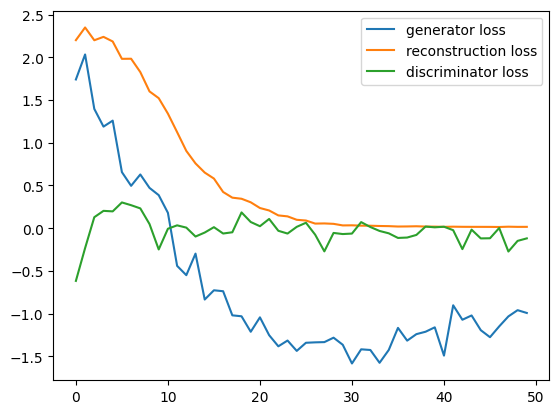

In [5]:
# LUCID-GAN
adult_preds = dir_adult_model.predict(adult.test_data.to_numpy())[:, 1]
adult_test_data = adult.inverse_preprocess(adult.test_data)
adult_data = pd.concat([adult_test_data, pd.DataFrame(adult_preds, columns=["preds"])], axis=1)

dir_adult_lucidgan = LUCIDGAN(epochs=50)

dir_adult_lucidgan.set_random_state(1234)
dir_adult_lucidgan.fit(adult_data, conditional=["preds"])

dir_adult_pos_samples = dir_adult_lucidgan.sample(1000, conditional=pd.DataFrame({"preds": [1]}))
dir_adult_neg_samples = dir_adult_lucidgan.sample(1000, conditional=pd.DataFrame({"preds": [0]}))

plt.plot(dir_adult_lucidgan.generator_loss, label = "generator loss")
plt.plot(dir_adult_lucidgan.reconstruction_loss, label = "reconstruction loss")
plt.plot(dir_adult_lucidgan.discriminator_loss, label = "discriminator loss")
plt.legend()
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_24692\1129162637.py:151: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dir_adult_pos_samples["Age"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1})
c:\Users\andre\AppData\Local\pypoetry\Cache\virtualenvs\canonical-sets-xMXl5KbK-py3.9\lib\site-packages\seaborn\distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\andre\AppData\Local\Temp\ipykernel_24692\1129162637.py:152: UserWarning: 



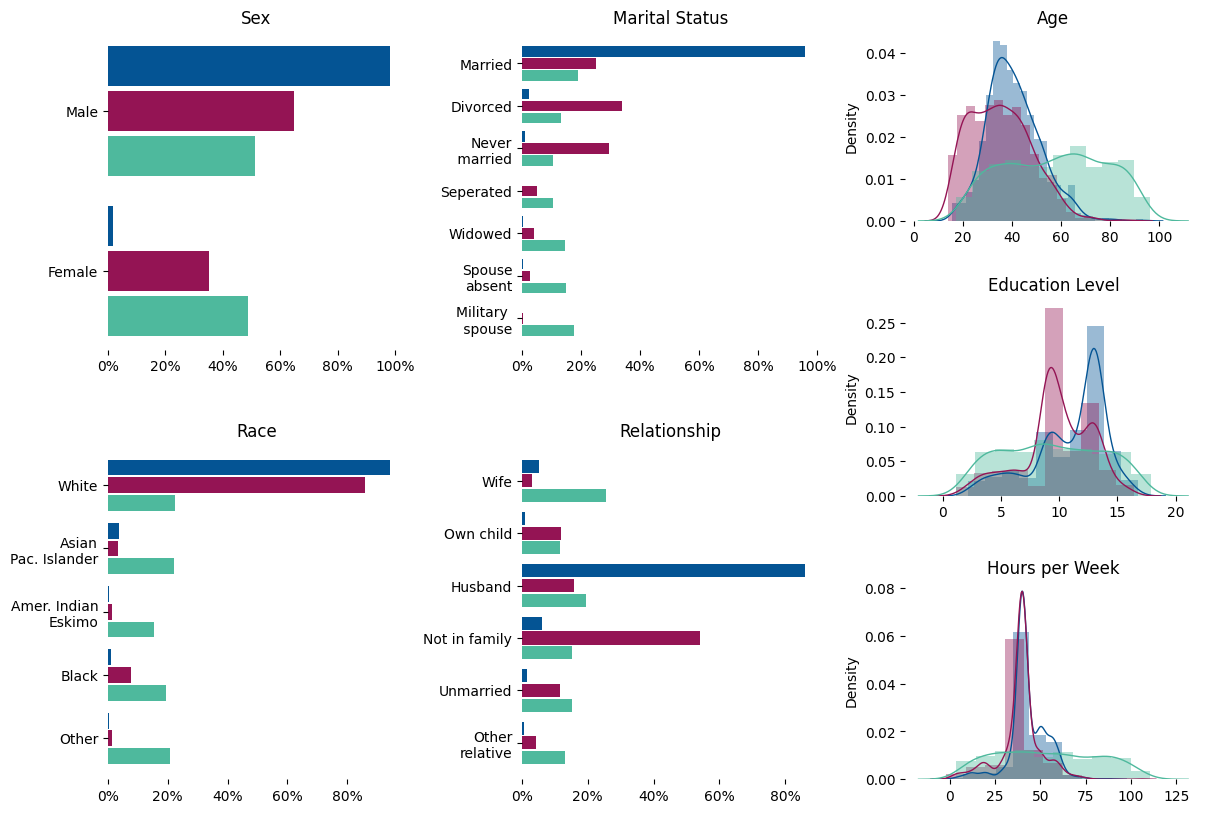

In [6]:
rcParams['axes.prop_cycle'] = cycler('color', ['#045494', '#941454', '#4eb99d'])

# Figure Adult: LUCID vs LUCID-GAN
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
spec = fig.add_gridspec(6, 3)
width = 0.25

# Fig 1
ax1 = fig.add_subplot(spec[0:3, 0:1])
ax1.set_title('Sex')
labels=['Male','Female']
x = np.arange(len(labels))

lucid_sex_count = adult_lucid.results_processed.query("epoch == 200").Sex.value_counts()
lucidgan_sex_count = dir_adult_pos_samples.Sex.value_counts()
lucidgan_sex_count_neg = dir_adult_neg_samples.Sex.value_counts()

missing = lucid_sex_count.index[~lucid_sex_count.index.isin(lucidgan_sex_count.index)].to_list()
for i in missing:
    lucidgan_sex_count[i] = 0

ax1.barh(x - width-0.03, [lucidgan_sex_count["Male"], lucidgan_sex_count["Female"]], width, label='LUCID-GAN')
ax1.barh(x, [lucidgan_sex_count_neg["Male"], lucidgan_sex_count_neg["Female"]], width, label='LUCID')
ax1.barh(x + width+0.03, [lucid_sex_count["Male"], lucid_sex_count["Female"]], width, label='LUCID')

ax1.set_yticks(x)
ax1.set_yticklabels(labels)
ax1.invert_yaxis()
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 2
ax2 = fig.add_subplot(spec[3:6,0:1])
ax2.set_title('Race')
labels=['White','Asian\nPac. Islander','Amer. Indian\nEskimo','Black','Other']
x = np.arange(len(labels))

lucid_race_count = adult_lucid.results_processed.query("epoch == 200").Race.value_counts()
lucidgan_race_count = dir_adult_pos_samples.Race.value_counts()
lucidgan_race_count_neg = dir_adult_neg_samples.Race.value_counts()

missing = lucid_race_count.index[~lucid_race_count.index.isin(lucidgan_race_count.index)].to_list()
for i in missing:
    lucidgan_race_count[i] = 0

missing = lucid_race_count.index[~lucid_race_count.index.isin(lucidgan_race_count_neg.index)].to_list()
for i in missing:
    lucidgan_race_count_neg[i] = 0

ax2.barh(x - width-0.03, [lucidgan_race_count["White"], lucidgan_race_count["Asian-Pac-Islander"],
                            lucidgan_race_count["Amer-Indian-Eskimo"], lucidgan_race_count["Black"],
                            lucidgan_race_count["Other"]], width, label='LUCID-GAN')
ax2.barh(x, [lucidgan_race_count_neg["White"], lucidgan_race_count_neg["Asian-Pac-Islander"],
                            lucidgan_race_count_neg["Amer-Indian-Eskimo"], lucidgan_race_count_neg["Black"],
                            lucidgan_race_count_neg["Other"]], width, label='LUCID-GAN')
ax2.barh(x + width+0.03, [lucid_race_count["White"], lucid_race_count["Asian-Pac-Islander"],
                            lucid_race_count["Amer-Indian-Eskimo"], lucid_race_count["Black"],
                            lucid_race_count["Other"]], width, label='LUCID')

ax2.set_yticks(x)
ax2.set_yticklabels(labels)
ax2.invert_yaxis()

ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 3
ax3 = fig.add_subplot(spec[0:3,1:2])
ax3.set_title('Marital Status')
labels=['Married','Divorced','Never\n married','Seperated','Widowed','Spouse\nabsent','Military \n spouse']
x = np.arange(len(labels))

lucid_status_count = adult_lucid.results_processed.query("epoch == 200")["Martial Status"].value_counts()
lucidgan_status_count = dir_adult_pos_samples["Martial Status"].value_counts()
lucidgan_status_count_neg = dir_adult_neg_samples["Martial Status"].value_counts()

missing = lucid_status_count.index[~lucid_status_count.index.isin(lucidgan_status_count.index)].to_list()
for i in missing:
    lucidgan_status_count[i] = 0

missing = lucid_status_count.index[~lucid_status_count.index.isin(lucidgan_status_count_neg.index)].to_list()
for i in missing:
    lucidgan_status_count_neg[i] = 0

ax3.barh(x - width-0.03, [lucidgan_status_count["Married-civ-spouse"], lucidgan_status_count["Divorced"],
                            lucidgan_status_count["Never-married"], lucidgan_status_count["Separated"],
                            lucidgan_status_count["Widowed"], lucidgan_status_count["Married-spouse-absent"],
                            lucidgan_status_count["Married-AF-spouse"]], width, label='LUCID-GAN')
ax3.barh(x, [lucidgan_status_count_neg["Married-civ-spouse"], lucidgan_status_count_neg["Divorced"],
                            lucidgan_status_count_neg["Never-married"], lucidgan_status_count_neg["Separated"],
                            lucidgan_status_count_neg["Widowed"], lucidgan_status_count_neg["Married-spouse-absent"],
                            lucidgan_status_count_neg["Married-AF-spouse"]], width, label='LUCID-GAN')
ax3.barh(x + width+0.03, [lucid_status_count["Married-civ-spouse"], lucid_status_count["Divorced"],
                            lucid_status_count["Never-married"], lucid_status_count["Separated"],
                            lucid_status_count["Widowed"], lucid_status_count["Married-spouse-absent"],
                            lucid_status_count["Married-AF-spouse"]], width, label='LUCID')
ax3.set_yticks(x)
ax3.set_yticklabels(labels)
ax3.invert_yaxis()

ax3.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 4
ax4 = fig.add_subplot(spec[3:6,1:2])
ax4.set_title('Relationship')
labels=["Wife", "Own child", "Husband", "Not in family", "Unmarried","Other\nrelative"]
x = np.arange(len(labels))

lucid_relation_count = adult_lucid.results_processed.query("epoch == 200")["Relationship"].value_counts()
lucidgan_relation_count = dir_adult_pos_samples["Relationship"].value_counts()
lucidgan_relation_count_neg = dir_adult_neg_samples["Relationship"].value_counts()

missing = lucid_relation_count.index[~lucid_relation_count.index.isin(lucidgan_relation_count.index)].to_list()
for i in missing:
    lucidgan_relation_count[i] = 0

missing = lucid_relation_count.index[~lucid_relation_count.index.isin(lucidgan_relation_count_neg.index)].to_list()
for i in missing:
    lucidgan_relation_count_neg[i] = 0

ax4.barh(x - width-0.03, [lucidgan_relation_count["Wife"], lucidgan_relation_count["Own-child"],
                            lucidgan_relation_count["Husband"], lucidgan_relation_count["Not-in-family"],
                            lucidgan_relation_count["Unmarried"], lucidgan_relation_count["Other-relative"]],
                            width, label='LUCID-GAN')
ax4.barh(x, [lucidgan_relation_count_neg["Wife"], lucidgan_relation_count_neg["Own-child"],
                            lucidgan_relation_count_neg["Husband"], lucidgan_relation_count_neg["Not-in-family"],
                            lucidgan_relation_count_neg["Unmarried"], lucidgan_relation_count_neg["Other-relative"]],
                            width, label='LUCID-GAN')
ax4.barh(x + width+0.03, [lucid_relation_count["Wife"], lucid_relation_count["Own-child"],
                            lucid_relation_count["Husband"], lucid_relation_count["Not-in-family"],
                            lucid_relation_count["Unmarried"], lucid_relation_count["Other-relative"]],
                            width, label='LUCID')

ax4.invert_yaxis()
ax4.set_yticks(x)
ax4.set_yticklabels(labels)

ax4.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 5
ax5 = fig.add_subplot(spec[ 0:2,-1])
ax5.set_title('Age')
plt.box(False)
# ax5.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=0.1,decimals=0))
sns.distplot(dir_adult_pos_samples["Age"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1})
sns.distplot(dir_adult_neg_samples["Age"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1})
sns.distplot(adult_lucid.results_processed.query("epoch == 200")["Age"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1})

plt.xlabel('')
plt.ylabel('Density')

# Fig 6
ax6 = fig.add_subplot(spec[2:4,-1])
ax6.set_title('Education Level')
plt.box(False)
# ax6.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=0.1,decimals=0))
sns.distplot(dir_adult_pos_samples["Education-Num"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, bins=10)
sns.distplot(dir_adult_neg_samples["Education-Num"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, bins=10)
sns.distplot(adult_lucid.results_processed.query("epoch == 200")["Education-Num"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, bins=10)

plt.xlabel('')
plt.ylabel('Density')

# Fig 7
ax7 = fig.add_subplot(spec[4:6,-1])
ax7.set_title('Hours per Week')
plt.box(False)
# ax7.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=0.1,decimals=0))
sns.distplot(dir_adult_pos_samples["Hours per week"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, bins=10)
sns.distplot(dir_adult_neg_samples["Hours per week"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, bins=10)
sns.distplot(adult_lucid.results_processed.query("epoch == 200")["Hours per week"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, bins=10)

plt.xlabel('')
plt.ylabel('Density')

plt.savefig("direct_discrimination_adult.pdf", format="pdf", bbox_inches='tight')

In [7]:
# Potential Indirect Discrimination
tf.keras.utils.set_random_seed(42)

callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)

adult = Adult()

protected_attributes = adult.train_data.columns[adult.train_data.columns.str.startswith(("Sex", "Race"))].to_list()
test_protected = adult._inverse_ohe(adult.test_data)[["Sex", "Race"]]

adult.train_data.drop(protected_attributes, axis=1, inplace=True)
adult.val_data.drop(protected_attributes, axis=1, inplace=True)
adult.test_data.drop(protected_attributes, axis=1, inplace=True)

ind_adult_model = ClassifierTF(2)
ind_adult_model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy"])
ind_adult_model.fit(adult.train_data.to_numpy(), adult.train_labels.to_numpy(), epochs=200,
 validation_data=(adult.val_data.to_numpy(), adult.val_labels.to_numpy()),
 callbacks=[callback], verbose=0)
print(f"Test accuracy: {ind_adult_model.evaluate(adult.test_data.to_numpy(), adult.test_labels.to_numpy())[1]}")

471/471 [==============================] - 0s 968us/step - loss: 0.3446 - accuracy: 0.8373
Test accuracy: 0.8372510075569153


In [8]:
# Output-based metrics
adult_preds = ind_adult_model.predict(adult.test_data.to_numpy())
adult_test_data = adult.inverse_preprocess(adult.test_data)

protected_attribute = "Relationship"

for i in adult_test_data[protected_attribute].unique().tolist():
    metrics = Metrics(adult.test_labels[adult_test_data[protected_attribute] == i][">50K"], adult_preds[adult_test_data[protected_attribute] == i].argmax(axis=1))
    print(i)
    print(metrics.metrics)

471/471 [==============================] - 0s 806us/step
Own-child
{'acc': 98.1, 'pr': 1.9, 'tpr': 100.0}
Husband
{'acc': 71.4, 'pr': 45.6, 'tpr': 72.5}
Not-in-family
{'acc': 91.2, 'pr': 10.2, 'tpr': 86.7}
Unmarried
{'acc': 94.7, 'pr': 5.6, 'tpr': 80.0}
Wife
{'acc': 72.1, 'pr': 47.0, 'tpr': 69.8}
Other-relative
{'acc': 97.2, 'pr': 3.3, 'tpr': 100.0}


471/471 [==============================] - 0s 806us/step


Epoch 49, Loss G: -1.2259, Loss R:  0.0112, Loss D:  0.0858: 100%|██████████| 50/50 [02:00<00:00,  2.40s/it]


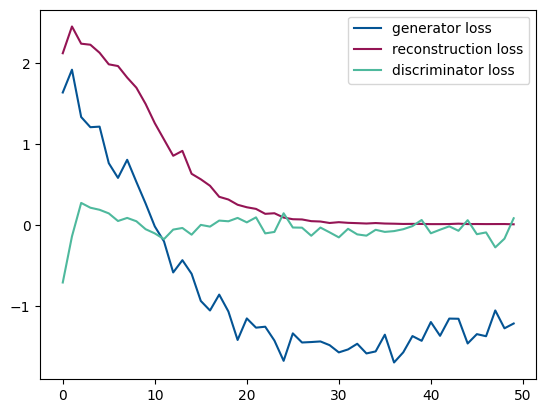

In [9]:
# LUCID-GAN with the inclusion of the protected attributes
adult_preds = ind_adult_model.predict(adult.test_data.to_numpy())[:, 1]
adult_test_data = adult.inverse_preprocess(adult.test_data)

adult_data = pd.concat([adult_test_data, test_protected, pd.DataFrame(adult_preds, columns=["preds"])], axis=1)

ind_adult_lucidgan = LUCIDGAN(epochs=50)

ind_adult_lucidgan.set_random_state(1234)
ind_adult_lucidgan.fit(adult_data, conditional=["preds"])

ind_adult_pos_samples = ind_adult_lucidgan.sample(1000, conditional=pd.DataFrame({"preds": [1]}))
ind_adult_neg_samples = ind_adult_lucidgan.sample(1000, conditional=pd.DataFrame({"preds": [0]}))

plt.plot(ind_adult_lucidgan.generator_loss, label = "generator loss")
plt.plot(ind_adult_lucidgan.reconstruction_loss, label = "reconstruction loss")
plt.plot(ind_adult_lucidgan.discriminator_loss, label = "discriminator loss")
plt.legend()
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_24692\1534532110.py:135: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ind_adult_pos_samples["Age"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1})
c:\Users\andre\AppData\Local\pypoetry\Cache\virtualenvs\canonical-sets-xMXl5KbK-py3.9\lib\site-packages\seaborn\distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\andre\AppData\Local\Temp\ipykernel_24692\1534532110.py:136: UserWarning: 



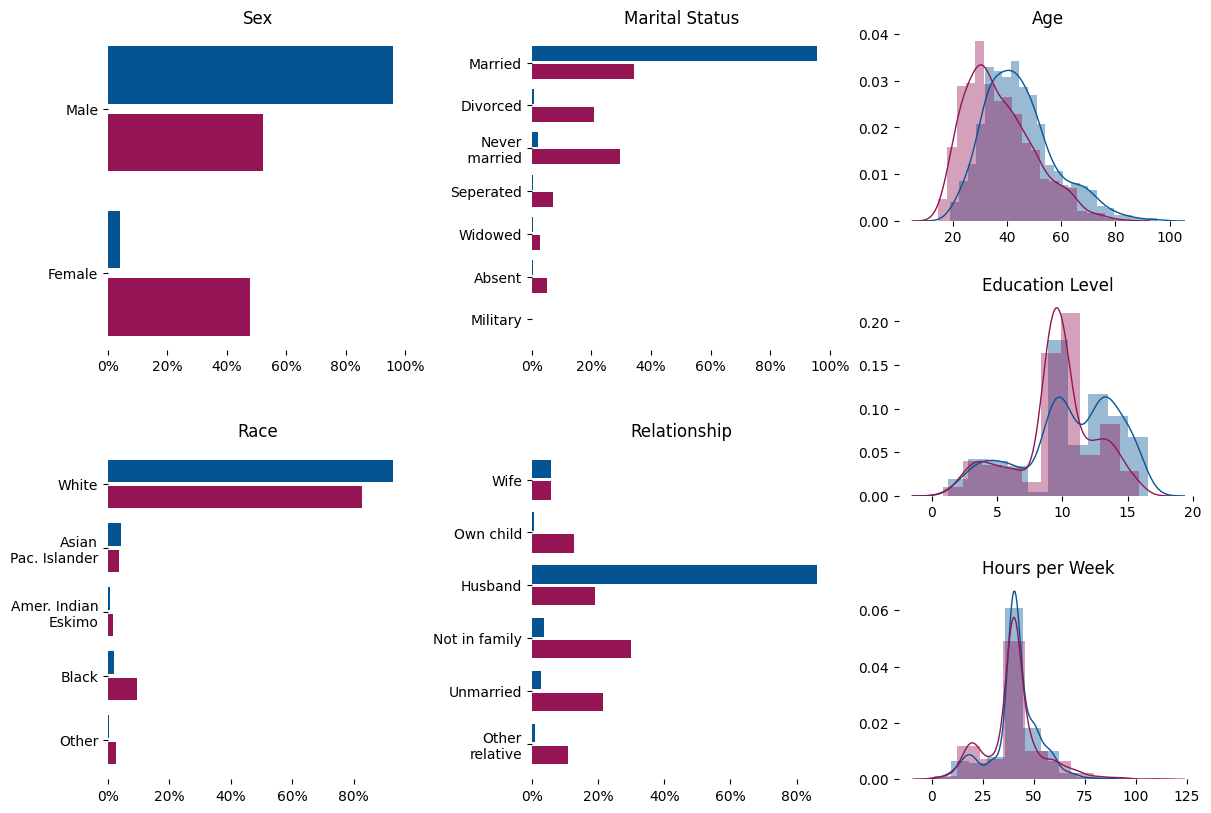

In [10]:
rcParams['axes.prop_cycle'] = cycler('color', ['#045494', '#941454'])

# Figure Adult
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
spec = fig.add_gridspec(6, 3)
width = 0.35

# Fig 1
ax1 = fig.add_subplot(spec[0:3, 0:1])
ax1.set_title('Sex')
labels=['Male','Female']
x = np.arange(len(labels))

lucidgan_sex_count = ind_adult_pos_samples.Sex.value_counts()
lucidgan_sex_count_neg = ind_adult_neg_samples.Sex.value_counts()

for i in adult_data["Sex"].unique()[[i not in lucidgan_sex_count for i in adult_data["Sex"].unique()]]:
    lucidgan_sex_count[i] = 0

for i in adult_data["Sex"].unique()[[i not in lucidgan_sex_count_neg for i in adult_data["Sex"].unique()]]:
    lucidgan_sex_count_neg[i] = 0

ax1.barh(x - width/2-0.03, [lucidgan_sex_count["Male"], lucidgan_sex_count["Female"]], width, label='LUCID-GAN')
ax1.barh(x + width/2+0.03, [lucidgan_sex_count_neg["Male"], lucidgan_sex_count_neg["Female"]], width, label='LUCID-GAN')

ax1.set_yticks(x)
ax1.set_yticklabels(labels)
ax1.invert_yaxis()
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 2
ax2 = fig.add_subplot(spec[3:6,0:1])
ax2.set_title('Race')
labels=['White','Asian\nPac. Islander','Amer. Indian\nEskimo','Black','Other']
x = np.arange(len(labels))

lucidgan_race_count = ind_adult_pos_samples.Race.value_counts()
lucidgan_race_count_neg = ind_adult_neg_samples.Race.value_counts()

for i in adult_data["Race"].unique()[[i not in lucidgan_race_count for i in adult_data["Race"].unique()]]:
    lucidgan_race_count[i] = 0

for i in adult_data["Race"].unique()[[i not in lucidgan_race_count_neg for i in adult_data["Race"].unique()]]:
    lucidgan_race_count_neg[i] = 0

ax2.barh(x - width/2-0.03, [lucidgan_race_count["White"], lucidgan_race_count["Asian-Pac-Islander"],
                            lucidgan_race_count["Amer-Indian-Eskimo"], lucidgan_race_count["Black"],
                            lucidgan_race_count["Other"]], width, label='LUCID-GAN')

ax2.barh(x + width/2+0.03, [lucidgan_race_count_neg["White"], lucidgan_race_count_neg["Asian-Pac-Islander"],
                            lucidgan_race_count_neg["Amer-Indian-Eskimo"], lucidgan_race_count_neg["Black"],
                            lucidgan_race_count_neg["Other"]], width, label='LUCID-GAN')

ax2.set_yticks(x)
ax2.set_yticklabels(labels)
ax2.invert_yaxis()

ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 3
ax3 = fig.add_subplot(spec[0:3,1:2])
ax3.set_title('Marital Status')
labels=['Married','Divorced','Never\n married','Seperated','Widowed','Absent','Military']
x = np.arange(len(labels))

lucidgan_status_count = ind_adult_pos_samples["Martial Status"].value_counts()
lucidgan_status_count_neg = ind_adult_neg_samples["Martial Status"].value_counts()

for i in adult_data["Martial Status"].unique()[[i not in lucidgan_status_count for i in adult_data["Martial Status"].unique()]]:
    lucidgan_status_count[i] = 0

for i in adult_data["Martial Status"].unique()[[i not in lucidgan_status_count_neg for i in adult_data["Martial Status"].unique()]]:
    lucidgan_status_count_neg[i] = 0

ax3.barh(x - width/2-0.03, [lucidgan_status_count["Married-civ-spouse"], lucidgan_status_count["Divorced"],
                            lucidgan_status_count["Never-married"], lucidgan_status_count["Separated"],
                            lucidgan_status_count["Widowed"], lucidgan_status_count["Married-spouse-absent"],
                            lucidgan_status_count["Married-AF-spouse"]], width, label='LUCID-GAN')

ax3.barh(x + width/2+0.03, [lucidgan_status_count_neg["Married-civ-spouse"], lucidgan_status_count_neg["Divorced"],
                            lucidgan_status_count_neg["Never-married"], lucidgan_status_count_neg["Separated"],
                            lucidgan_status_count_neg["Widowed"], lucidgan_status_count_neg["Married-spouse-absent"],
                            lucidgan_status_count_neg["Married-AF-spouse"]], width, label='LUCID-GAN')

ax3.set_yticks(x)
ax3.set_yticklabels(labels)
ax3.invert_yaxis()

ax3.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 4
ax4 = fig.add_subplot(spec[3:6,1:2])
ax4.set_title('Relationship')
labels=["Wife", "Own child", "Husband", "Not in family", "Unmarried","Other\nrelative"]
x = np.arange(len(labels))

lucidgan_relation_count = ind_adult_pos_samples["Relationship"].value_counts()
lucidgan_relation_count_neg = ind_adult_neg_samples["Relationship"].value_counts()

for i in adult_data["Relationship"].unique()[[i not in lucidgan_relation_count for i in adult_data["Relationship"].unique()]]:
    lucidgan_relation_count[i] = 0

for i in adult_data["Relationship"].unique()[[i not in lucidgan_relation_count_neg for i in adult_data["Relationship"].unique()]]:
    lucidgan_relation_count_neg[i] = 0

ax4.barh(x - width/2-0.03, [lucidgan_relation_count["Wife"], lucidgan_relation_count["Own-child"],
                            lucidgan_relation_count["Husband"], lucidgan_relation_count["Not-in-family"],
                            lucidgan_relation_count["Unmarried"], lucidgan_relation_count["Other-relative"]],
                            width, label='LUCID-GAN')

ax4.barh(x + width/2+0.03, [lucidgan_relation_count_neg["Wife"], lucidgan_relation_count_neg["Own-child"],
                            lucidgan_relation_count_neg["Husband"], lucidgan_relation_count_neg["Not-in-family"],
                            lucidgan_relation_count_neg["Unmarried"], lucidgan_relation_count_neg["Other-relative"]],
                            width, label='LUCID-GAN')

ax4.invert_yaxis()
ax4.set_yticks(x)
ax4.set_yticklabels(labels)

ax4.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 5
ax5 = fig.add_subplot(spec[0:2,-1])
ax5.set_title('Age')
plt.box(False)
# ax5.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=0.1,decimals=0))
sns.distplot(ind_adult_pos_samples["Age"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1})
sns.distplot(ind_adult_neg_samples["Age"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1})

plt.xlabel('')
plt.ylabel('')

# Fig 6
ax6 = fig.add_subplot(spec[2:4,-1])
ax6.set_title('Education Level')
plt.box(False)
# ax6.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=0.1,decimals=0))
sns.distplot(ind_adult_pos_samples["Education-Num"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, bins=10)
sns.distplot(ind_adult_neg_samples["Education-Num"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, bins=10)

plt.xlabel('')
plt.ylabel('')

# Fig 7
ax7 = fig.add_subplot(spec[4:6,-1])
ax7.set_title('Hours per Week')
plt.box(False)
# ax7.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=0.1,decimals=0))
sns.distplot(ind_adult_pos_samples["Hours per week"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, bins=10)
sns.distplot(ind_adult_neg_samples["Hours per week"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, bins=10)

plt.xlabel('')
plt.ylabel('')

plt.savefig("indirect_discrimination_adult_pos_neg.pdf", format="pdf", bbox_inches='tight')

C:\Users\andre\AppData\Local\Temp\ipykernel_24692\2403166713.py:109: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adult_lucid.results_processed.query("epoch == 200")["Age"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1})
c:\Users\andre\AppData\Local\pypoetry\Cache\virtualenvs\canonical-sets-xMXl5KbK-py3.9\lib\site-packages\seaborn\distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\andre\AppData\Local\Temp\ipykernel_24692\2403

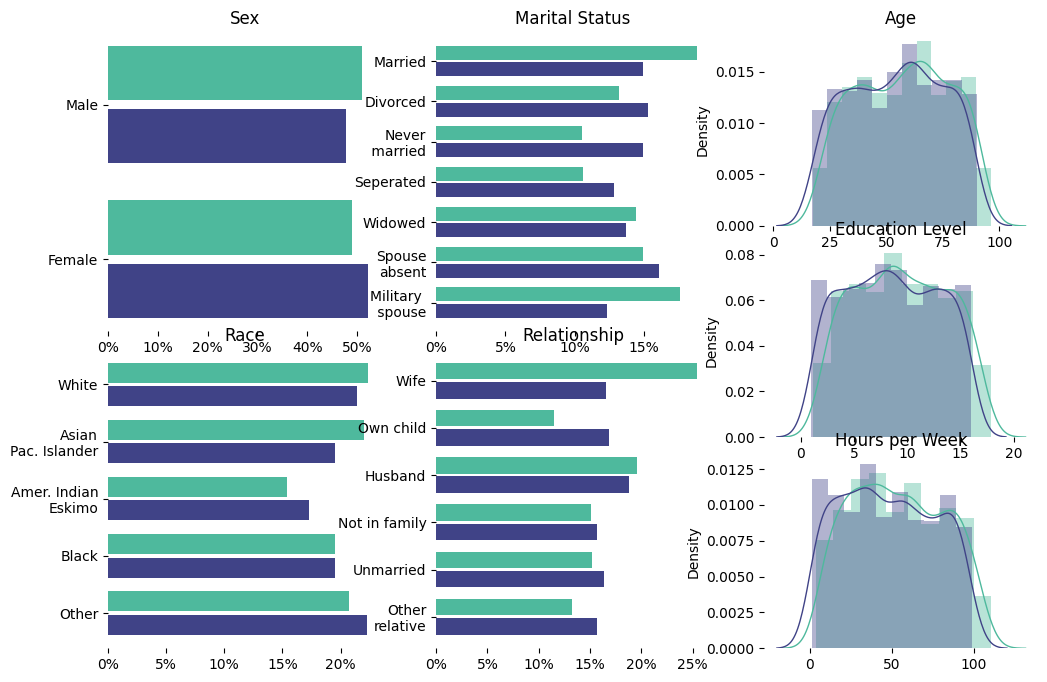

In [11]:
rcParams['axes.prop_cycle'] = cycler('color', ['#4eb99d', '#404387'])

# LUCID vs Uniform
fig = plt.figure(constrained_layout=False, figsize=(12, 8))
spec = fig.add_gridspec(6, 3)
width = 0.35

# Fig 1
ax1 = fig.add_subplot(spec[0:3, 0:1])
ax1.set_title('Sex')
labels=['Male','Female']
x = np.arange(len(labels))

lucidint_sex_count = adult_lucid.results_processed.query("epoch == 1").Sex.value_counts()
lucid_sex_count = adult_lucid.results_processed.query("epoch == 200").Sex.value_counts()

ax1.barh(x - width/2-0.03, [lucid_sex_count["Male"], lucid_sex_count["Female"]], width, label='LUCID')
ax1.barh(x + width/2+0.03, [lucidint_sex_count["Male"], lucidint_sex_count["Female"]], width, label='LUCID-GAN')

ax1.set_yticks(x)
ax1.set_yticklabels(labels)
ax1.invert_yaxis()
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 2
ax2 = fig.add_subplot(spec[3:6,0:1])
ax2.set_title('Race')
labels=['White','Asian\nPac. Islander','Amer. Indian\nEskimo','Black','Other']
x = np.arange(len(labels))

lucidint_race_count = adult_lucid.results_processed.query("epoch == 1").Race.value_counts()
lucid_race_count = adult_lucid.results_processed.query("epoch == 200").Race.value_counts()


ax2.barh(x - width/2-0.03, [lucid_race_count["White"], lucid_race_count["Asian-Pac-Islander"],
                            lucid_race_count["Amer-Indian-Eskimo"], lucid_race_count["Black"],
                            lucid_race_count["Other"]], width, label='LUCID')
ax2.barh(x + width/2+0.03, [lucidint_race_count["White"], lucidint_race_count["Asian-Pac-Islander"],
                            lucidint_race_count["Amer-Indian-Eskimo"], lucidint_race_count["Black"],
                            lucidint_race_count["Other"]], width, label='LUCID')

ax2.set_yticks(x)
ax2.set_yticklabels(labels)
ax2.invert_yaxis()

ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 3
ax3 = fig.add_subplot(spec[0:3,1:2])
ax3.set_title('Marital Status')
labels=['Married','Divorced','Never\n married','Seperated','Widowed','Spouse\nabsent','Military \n spouse']
x = np.arange(len(labels))

lucidint_status_count = adult_lucid.results_processed.query("epoch == 1")["Martial Status"].value_counts()
lucid_status_count = adult_lucid.results_processed.query("epoch == 200")["Martial Status"].value_counts()

ax3.barh(x - width/2-0.03, [lucid_status_count["Married-civ-spouse"], lucid_status_count["Divorced"],
                            lucid_status_count["Never-married"], lucid_status_count["Separated"],
                            lucid_status_count["Widowed"], lucid_status_count["Married-spouse-absent"],
                            lucid_status_count["Married-AF-spouse"]], width, label='LUCID')
ax3.barh(x + width/2+0.03, [lucidint_status_count["Married-civ-spouse"], lucidint_status_count["Divorced"],
                            lucidint_status_count["Never-married"], lucidint_status_count["Separated"],
                            lucidint_status_count["Widowed"], lucidint_status_count["Married-spouse-absent"],
                            lucidint_status_count["Married-AF-spouse"]], width, label='LUCID')

ax3.set_yticks(x)
ax3.set_yticklabels(labels)
ax3.invert_yaxis()

ax3.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 4
ax4 = fig.add_subplot(spec[3:6,1:2])
ax4.set_title('Relationship')
labels=["Wife", "Own child", "Husband", "Not in family", "Unmarried","Other\nrelative"]
x = np.arange(len(labels))

lucidint_relation_count = adult_lucid.results_processed.query("epoch == 1")["Relationship"].value_counts()
lucid_relation_count = adult_lucid.results_processed.query("epoch == 200")["Relationship"].value_counts()

ax4.barh(x - width/2-0.03, [lucid_relation_count["Wife"], lucid_relation_count["Own-child"],
                            lucid_relation_count["Husband"], lucid_relation_count["Not-in-family"],
                            lucid_relation_count["Unmarried"], lucid_relation_count["Other-relative"]],
                            width, label='LUCID')
ax4.barh(x + width/2+0.03, [lucidint_relation_count["Wife"], lucidint_relation_count["Own-child"],
                            lucidint_relation_count["Husband"], lucidint_relation_count["Not-in-family"],
                            lucidint_relation_count["Unmarried"], lucidint_relation_count["Other-relative"]],
                            width, label='LUCID')

ax4.invert_yaxis()
ax4.set_yticks(x)
ax4.set_yticklabels(labels)

ax4.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 5
ax5 = fig.add_subplot(spec[ 0:2,-1])
ax5.set_title('Age')
plt.box(False)
# ax5.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=0.1,decimals=0))
sns.distplot(adult_lucid.results_processed.query("epoch == 200")["Age"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1})
sns.distplot(adult_lucid.results_processed.query("epoch == 1")["Age"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1})

plt.xlabel('')
plt.ylabel('Density')

# Fig 6
ax6 = fig.add_subplot(spec[ 2:4,-1])
ax6.set_title('Education Level')
plt.box(False)
# ax6.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=0.1,decimals=0))
sns.distplot(adult_lucid.results_processed.query("epoch == 200")["Education-Num"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, bins=10)
sns.distplot(adult_lucid.results_processed.query("epoch == 1")["Education-Num"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, bins=10)

plt.xlabel('')
plt.ylabel('Density')

# Fig 7
ax7 = fig.add_subplot(spec[ 4:6,-1])
ax7.set_title('Hours per Week')
plt.box(False)
# ax7.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=0.1,decimals=0))
sns.distplot(adult_lucid.results_processed.query("epoch == 200")["Hours per week"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, bins=10)
sns.distplot(adult_lucid.results_processed.query("epoch == 1")["Hours per week"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, bins=10)

plt.xlabel('')
plt.ylabel('Density')

plt.savefig("lucid_adult.pdf", format="pdf", bbox_inches='tight')

C:\Users\andre\AppData\Local\Temp\ipykernel_24692\3504624694.py:135: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dir_adult_pos_samples["Age"] - ind_adult_pos_samples["Age"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1})
c:\Users\andre\AppData\Local\pypoetry\Cache\virtualenvs\canonical-sets-xMXl5KbK-py3.9\lib\site-packages\seaborn\distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\andre\AppData\Local\Temp\ipykernel_24692\350

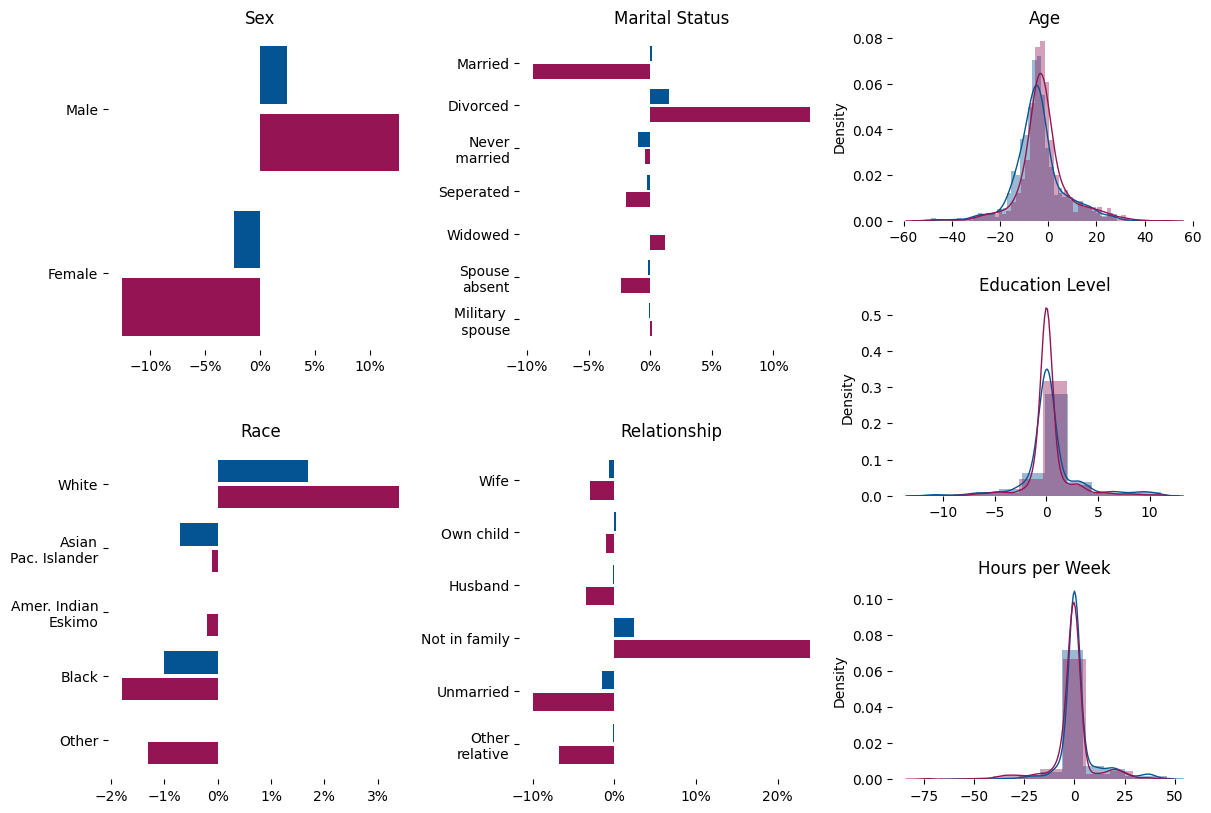

In [12]:
rcParams['axes.prop_cycle'] = cycler('color', ['#045494', '#941454'])

# Differences direct vs indirect discrimination
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
spec = fig.add_gridspec(6, 3)
width = 0.35

# Fig 1
ax1 = fig.add_subplot(spec[0:3, 0:1])
ax1.set_title('Sex')
labels=['Male','Female']
x = np.arange(len(labels))

lucidgan_sex_count = dir_adult_pos_samples.Sex.value_counts().sort_index() - ind_adult_pos_samples.Sex.value_counts().sort_index()
lucidgan_sex_count_neg = dir_adult_neg_samples.Sex.value_counts().sort_index() - ind_adult_neg_samples.Sex.value_counts().sort_index()

for i in adult_data["Sex"].unique()[[i not in lucidgan_sex_count for i in adult_data["Sex"].unique()]]:
    lucidgan_sex_count[i] = 0

for i in adult_data["Sex"].unique()[[i not in lucidgan_sex_count_neg for i in adult_data["Sex"].unique()]]:
    lucidgan_sex_count_neg[i] = 0

ax1.barh(x - width/2-0.03, [lucidgan_sex_count["Male"], lucidgan_sex_count["Female"]], width, label='LUCID-GAN')
ax1.barh(x + width/2+0.03, [lucidgan_sex_count_neg["Male"], lucidgan_sex_count_neg["Female"]], width, label='LUCID-GAN')

ax1.set_yticks(x)
ax1.set_yticklabels(labels)
ax1.invert_yaxis()
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 2
ax2 = fig.add_subplot(spec[3:6,0:1])
ax2.set_title('Race')
labels=['White','Asian\nPac. Islander','Amer. Indian\nEskimo','Black','Other']
x = np.arange(len(labels))

lucidgan_race_count = dir_adult_pos_samples.Race.value_counts().sort_index() - ind_adult_pos_samples.Race.value_counts().sort_index()
lucidgan_race_count_neg = dir_adult_neg_samples.Race.value_counts().sort_index() - ind_adult_neg_samples.Race.value_counts().sort_index()

for i in adult_data["Race"].unique()[[i not in lucidgan_race_count for i in adult_data["Race"].unique()]]:
    lucidgan_race_count[i] = 0

for i in adult_data["Race"].unique()[[i not in lucidgan_race_count_neg for i in adult_data["Race"].unique()]]:
    lucidgan_race_count_neg[i] = 0

ax2.barh(x - width/2-0.03, [lucidgan_race_count["White"], lucidgan_race_count["Asian-Pac-Islander"],
                            lucidgan_race_count["Amer-Indian-Eskimo"], lucidgan_race_count["Black"],
                            lucidgan_race_count["Other"]], width, label='LUCID-GAN')

ax2.barh(x + width/2+0.03, [lucidgan_race_count_neg["White"], lucidgan_race_count_neg["Asian-Pac-Islander"],
                            lucidgan_race_count_neg["Amer-Indian-Eskimo"], lucidgan_race_count_neg["Black"],
                            lucidgan_race_count_neg["Other"]], width, label='LUCID-GAN')

ax2.set_yticks(x)
ax2.set_yticklabels(labels)
ax2.invert_yaxis()

ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 3
ax3 = fig.add_subplot(spec[0:3,1:2])
ax3.set_title('Marital Status')
labels=['Married','Divorced','Never\n married','Seperated','Widowed','Spouse\nabsent','Military \n spouse']
x = np.arange(len(labels))

lucidgan_status_count = dir_adult_pos_samples["Martial Status"].value_counts().sort_index() - ind_adult_pos_samples["Martial Status"].value_counts().sort_index()
lucidgan_status_count_neg = dir_adult_neg_samples["Martial Status"].value_counts().sort_index() - ind_adult_neg_samples["Martial Status"].value_counts().sort_index()

for i in adult_data["Martial Status"].unique()[[i not in lucidgan_status_count for i in adult_data["Martial Status"].unique()]]:
    lucidgan_status_count[i] = 0

for i in adult_data["Martial Status"].unique()[[i not in lucidgan_status_count_neg for i in adult_data["Martial Status"].unique()]]:
    lucidgan_status_count_neg[i] = 0

ax3.barh(x - width/2-0.03, [lucidgan_status_count["Married-civ-spouse"], lucidgan_status_count["Divorced"],
                            lucidgan_status_count["Never-married"], lucidgan_status_count["Separated"],
                            lucidgan_status_count["Widowed"], lucidgan_status_count["Married-spouse-absent"],
                            lucidgan_status_count["Married-AF-spouse"]], width, label='LUCID-GAN')

ax3.barh(x + width/2+0.03, [lucidgan_status_count_neg["Married-civ-spouse"], lucidgan_status_count_neg["Divorced"],
                            lucidgan_status_count_neg["Never-married"], lucidgan_status_count_neg["Separated"],
                            lucidgan_status_count_neg["Widowed"], lucidgan_status_count_neg["Married-spouse-absent"],
                            lucidgan_status_count_neg["Married-AF-spouse"]], width, label='LUCID-GAN')

ax3.set_yticks(x)
ax3.set_yticklabels(labels)
ax3.invert_yaxis()

ax3.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 4
ax4 = fig.add_subplot(spec[ 3:6,1:2])
ax4.set_title('Relationship')
labels=["Wife", "Own child", "Husband", "Not in family", "Unmarried","Other\nrelative"]
x = np.arange(len(labels))

lucidgan_relation_count = dir_adult_pos_samples["Relationship"].value_counts().sort_index() - ind_adult_pos_samples["Relationship"].value_counts().sort_index()
lucidgan_relation_count_neg = dir_adult_neg_samples["Relationship"].value_counts().sort_index() - ind_adult_neg_samples["Relationship"].value_counts().sort_index()

for i in adult_data["Relationship"].unique()[[i not in lucidgan_relation_count for i in adult_data["Relationship"].unique()]]:
    lucidgan_relation_count[i] = 0

for i in adult_data["Relationship"].unique()[[i not in lucidgan_relation_count_neg for i in adult_data["Relationship"].unique()]]:
    lucidgan_relation_count_neg[i] = 0

ax4.barh(x - width/2-0.03, [lucidgan_relation_count["Wife"], lucidgan_relation_count["Own-child"],
                            lucidgan_relation_count["Husband"], lucidgan_relation_count["Not-in-family"],
                            lucidgan_relation_count["Unmarried"], lucidgan_relation_count["Other-relative"]],
                            width, label='LUCID-GAN')

ax4.barh(x + width/2+0.03, [lucidgan_relation_count_neg["Wife"], lucidgan_relation_count_neg["Own-child"],
                            lucidgan_relation_count_neg["Husband"], lucidgan_relation_count_neg["Not-in-family"],
                            lucidgan_relation_count_neg["Unmarried"], lucidgan_relation_count_neg["Other-relative"]],
                            width, label='LUCID-GAN')

ax4.invert_yaxis()
ax4.set_yticks(x)
ax4.set_yticklabels(labels)

ax4.xaxis.set_major_formatter(mtick.PercentFormatter(1000, decimals=0))

plt.box(False)

# Fig 5
ax5 = fig.add_subplot(spec[ 0:2,-1])
ax5.set_title('Age')
plt.box(False)
# ax5.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=0.1,decimals=0))
sns.distplot(dir_adult_pos_samples["Age"] - ind_adult_pos_samples["Age"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1})
sns.distplot(dir_adult_neg_samples["Age"] - ind_adult_neg_samples["Age"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1})

plt.xlabel('')
plt.ylabel('Density')

# Fig 6
ax6 = fig.add_subplot(spec[ 2:4,-1])
ax6.set_title('Education Level')
plt.box(False)
# ax6.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=0.1,decimals=0))
sns.distplot(dir_adult_pos_samples["Education-Num"] - ind_adult_pos_samples["Education-Num"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, bins=10)
sns.distplot(dir_adult_neg_samples["Education-Num"] - ind_adult_neg_samples["Education-Num"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, bins=10)

plt.xlabel('')
plt.ylabel('Density')

# Fig 7
ax7 = fig.add_subplot(spec[ 4:6,-1])
ax7.set_title('Hours per Week')
plt.box(False)
# ax7.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=0.1,decimals=0))
sns.distplot(dir_adult_pos_samples["Hours per week"] - ind_adult_pos_samples["Hours per week"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, bins=10)
sns.distplot(dir_adult_neg_samples["Hours per week"] - ind_adult_neg_samples["Hours per week"], hist = True, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, bins=10)

plt.xlabel('')
plt.ylabel('Density')

plt.savefig("compare_adult.pdf", format="pdf", bbox_inches='tight')

In [13]:
# Intersectional Discrimination
tf.keras.utils.set_random_seed(42)

callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)

adult = Adult()
dir_adult_model = ClassifierTF(2)
dir_adult_model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy"])
dir_adult_model.fit(adult.train_data.to_numpy(), adult.train_labels.to_numpy(), epochs=200,
 validation_data=(adult.val_data.to_numpy(), adult.val_labels.to_numpy()),
 callbacks=[callback], verbose=0)
print(f"Test accuracy: {dir_adult_model.evaluate(adult.test_data.to_numpy(), adult.test_labels.to_numpy())[1]}")

471/471 [==============================] - 0s 944us/step - loss: 0.3442 - accuracy: 0.8386
Test accuracy: 0.838578999042511


471/471 [==============================] - 0s 808us/step


Epoch 49, Loss G: -1.0084, Loss R:  0.0154, Loss D: -0.1195: 100%|██████████| 50/50 [01:50<00:00,  2.22s/it]


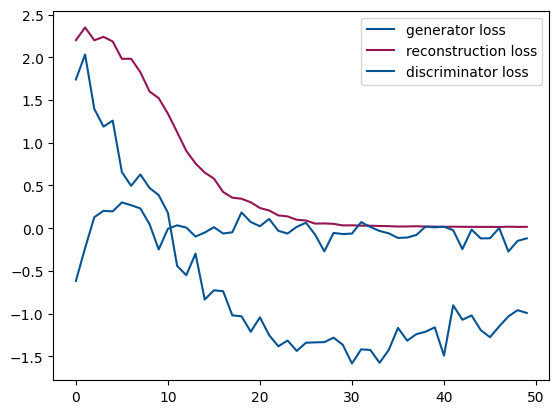

In [14]:
# LUCID-GAN
adult_preds = dir_adult_model.predict(adult.test_data.to_numpy())[:, 1]
adult_test_data = adult.inverse_preprocess(adult.test_data)
adult_data = pd.concat([adult_test_data, pd.DataFrame(adult_preds, columns=["preds"])], axis=1)

int_adult_lucidgan = LUCIDGAN(epochs=50)

int_adult_lucidgan.set_random_state(1234)
int_adult_lucidgan.fit(adult_data, conditional=["preds"])

plt.plot(int_adult_lucidgan.generator_loss, label = "generator loss")
plt.plot(int_adult_lucidgan.reconstruction_loss, label = "reconstruction loss")
plt.plot(int_adult_lucidgan.discriminator_loss, label = "discriminator loss")
plt.legend()
plt.show()

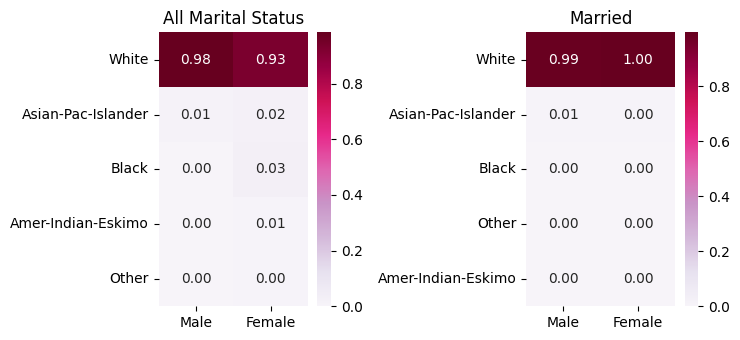

In [15]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=5.51)

int_adult_male_samples = int_adult_lucidgan.sample(1000, condition_column="Sex", condition_value="Male", conditional=pd.DataFrame({"preds": [1]}))
int_adult_female_samples = int_adult_lucidgan.sample(1000, condition_column="Sex", condition_value="Female", conditional=pd.DataFrame({"preds": [1]}))

int_adult_male_samples = int_adult_male_samples.Race.value_counts(normalize=True)
int_adult_female_samples = int_adult_female_samples.Race.value_counts(normalize=True)

int_compas_sex_samples = pd.concat([int_adult_male_samples, int_adult_female_samples], axis=1).fillna(0)
int_compas_sex_samples.columns = ["Male", "Female"]

sns.heatmap(int_compas_sex_samples, cmap="PuRd", shading='auto', annot=True, fmt=".2f", ax=ax1)
ax1.set_title("All Marital Status")

int_adult_male_samples = int_adult_lucidgan.sample(1000, condition_column=["Sex", "Martial Status"], condition_value=["Male", "Married-civ-spouse"], conditional=pd.DataFrame({"preds": [1]}))
int_adult_female_samples = int_adult_lucidgan.sample(1000, condition_column=["Sex", "Martial Status"], condition_value=["Male", "Married-civ-spouse"], conditional=pd.DataFrame({"preds": [1]}))

int_adult_male_samples = int_adult_male_samples.Race.value_counts(normalize=True)
int_adult_female_samples = int_adult_female_samples.Race.value_counts(normalize=True)

int_compas_sex_samples = pd.concat([int_adult_male_samples, int_adult_female_samples], axis=1).fillna(0)
int_compas_sex_samples.columns = ["Male", "Female"]

for i in adult_test_data.Race.unique():
    if i not in int_compas_sex_samples.index.tolist():
        int_compas_sex_samples.loc[i] = 0

sns.heatmap(int_compas_sex_samples, cmap="PuRd", shading='auto', annot=True, fmt=".2f", ax=ax2)
ax2.set_title("Married")

plt.savefig("intersectional_adult.pdf", format="pdf", bbox_inches='tight')